# Laboratorio 3
## Microestructuras y Sistemas de Trading
###  Karen Medel y Pablo Mendoza


In [1]:
# -- Libraries Importation -- #
import ta as ta
import numpy as np
%matplotlib inline
import pandas as pd
from datetime import date
from oandapyV20 import API
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import oandapyV20.endpoints.instruments as instruments
# -- Ignore warnings -- #
import warnings
warnings.filterwarnings("ignore")
# -- DataFrame Parameters -- #
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


The objective of this project is to simulate and validate with historical data a trading algorithm that open and close operations with technical analysis (T.A.) as indicator to trade the USD/MXN. For the project, the 3 tools from T.A. that will serve as indicators are the Relative Strength Index (RSI), the Stochastic Oscillator (SO) and the Bollinger Bands (BB).\

The historical prices are obtained fron OANDA group with a frequency of 5 minutes. This implies that operations of opening and closing positions may be made every 5 minutes.\

Assumptions of the model:\
* There are no transaction fees of commission or spread types (though, they can be added easily).
* Operations are made instantly, therefore price is respected at the moment of the transaction.
* There is a finite amount of money to invest.
* Leverage is not considered in the project.

In [2]:
# -- OANDA Parameters -- #
A1_OA_Da = 16                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align
A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta
A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas (Minutes 5)
A1_OA_Ak = '4' + 'df969137c0bf800c5a04604c49450db-0e783d4124aa50b5736ebfe1a350eac' + '1'

# -- Data Range Function -- # 


def date_range(start_date_, end_date_, increment, period):
    """
    This function creates a list of the data range that will be imported
    :param start_date_: Start Date
    :param end_date_: End Date
    :param increment: number of increments
    :param period: type of increment (days, hours, minutes, etc)
    :return: list of the data range
    """
    result = []
    nxt = start_date_
    delta = relativedelta(**{period: increment})
    while nxt <= end_date_:
        result.append(nxt)
        nxt += delta
    return result


In [3]:
-- Download Initial Data -- #
start_date = date(2017, 2, 16)  # Date for all transactions date(2017, 2, 16)
end_date = date(2019, 3, 5)  # Date for all transactions date(2019, 3, 5)
date_a = date_range(start_date, end_date, 1, 'days')
list_a = []
for n_date in range(len(date_a)-1):
    F1 = date_a[n_date].strftime('%Y-%m-%dT%H:%M:%S')
    F2 = date_a[n_date+1].strftime('%Y-%m-%dT%H:%M:%S')

    # -- OANDA API Initialisation -- #
    api = API(access_token=A1_OA_Ak)
    # -- Historical DAta Download -- #
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    for i in range(len(A1_Hist['candles'])-1):
            list_a.append({'TimeStamp': A1_Hist['candles'][i]['time'],
                           'Open': A1_Hist['candles'][i]['mid']['o'],
                           'High': A1_Hist['candles'][i]['mid']['h'],
                           'Low': A1_Hist['candles'][i]['mid']['l'],
                           'Close': A1_Hist['candles'][i]['mid']['c']})

pd_hist = pd.DataFrame(list_a)
pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
pd_hist['Open'] = pd.to_numeric(pd_hist['Open'])
pd_hist['High'] = pd.to_numeric(pd_hist['High'])
pd_hist['Low'] = pd.to_numeric(pd_hist['Low'])
pd_hist['Close'] = pd.to_numeric(pd_hist['Close'])
-- Data Structure -- #
df1_Prices = pd_hist


In [4]:
# df1_Prices.to_csv('Data_Set_Technical_Analysis.csv')  # Importation of Data Set from CSV
df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # all data with size (151536, 6)
df1_Prices = df1_Prices.iloc[:1000, :]  # For sampling Data from the Data Set


In [5]:
print('This is the beginning of the Historical Data')
df1_Prices.head()


This is the beginning of the Historical Data


,Unnamed: 0,TimeStamp,Open,High,Low,Close
0,0,2017-02-16 05:00:00+00:00,20.29110,20.29142,20.28996,20.29036
1,1,2017-02-16 05:05:00+00:00,20.29037,20.29141,20.28994,20.29061
2,2,2017-02-16 05:10:00+00:00,20.29060,20.29141,20.29060,20.29120
3,3,2017-02-16 05:15:00+00:00,20.29118,20.29186,20.29108,20.29164
4,4,2017-02-16 05:20:00+00:00,20.29162,20.29221,20.29014,20.29030


In [6]:
print('This is the end of the Historical Data')
df1_Prices.tail()


This is the end of the Historical Data


,Unnamed: 0,TimeStamp,Open,High,Low,Close
995,995,2017-02-21 16:25:00+00:00,20.45326,20.45559,20.43881,20.43890
996,996,2017-02-21 16:30:00+00:00,20.43885,20.43910,20.43202,20.43464
997,997,2017-02-21 16:35:00+00:00,20.43462,20.43462,20.42140,20.42504
998,998,2017-02-21 16:40:00+00:00,20.42503,20.43180,20.42388,20.42764
999,999,2017-02-21 16:45:00+00:00,20.42764,20.43099,20.42460,20.42882


## Technical Analysis Indicators/
The library of **ta**, helps to calculate the Bollinger Bands, RSI and the Stochastic Oscillator for a time series, based on its close price. 

In [7]:
# -- Technical Analysis Indicators Calculations -- #
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], 
                                            df1_Prices['Close'], 200, False)
df1_Prices.head()


,Unnamed: 0,TimeStamp,Open,High,Low,Close,BBH_Close,BBL_Close,RSI_Close,STO_Close
0,0,2017-02-16 05:00:00+00:00,20.29110,20.29142,20.28996,20.29036,NaN,NaN,NaN,NaN
1,1,2017-02-16 05:05:00+00:00,20.29037,20.29141,20.28994,20.29061,NaN,NaN,NaN,NaN
2,2,2017-02-16 05:10:00+00:00,20.29060,20.29141,20.29060,20.29120,NaN,NaN,NaN,NaN
3,3,2017-02-16 05:15:00+00:00,20.29118,20.29186,20.29108,20.29164,NaN,NaN,NaN,NaN
4,4,2017-02-16 05:20:00+00:00,20.29162,20.29221,20.29014,20.29030,NaN,NaN,NaN,NaN


Here are some Graphs to show the way the 3 indicators from T.A., behave during the observable time sample of the USD/MXN.\
For the project, the written functions on the next section, will Open positions depending of the values of each T.A. indicators.\
* Bollinger Bands activate when the spot cross the Bollinger Bands from bellow(High Band) and from above(Low Band).
* RSI_Param_UP = 75
* RSI_Param_DW = 25
* STO_Param_UP = 90
* STO_Param_DW = 10
\
For the project, the written functions on the next section, will Close positions depending of the values of TP and SL levels.\
* For opening operations, Take Profit (TP) level will be 200 pips from spot.
* For closing operations, Stop Loss (SL) level will be 100 pips from spot.
# TP and SL levels will be above or below spot depending if the position is Long or Short.

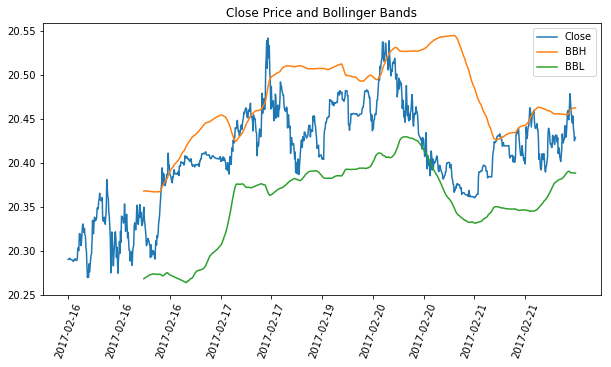

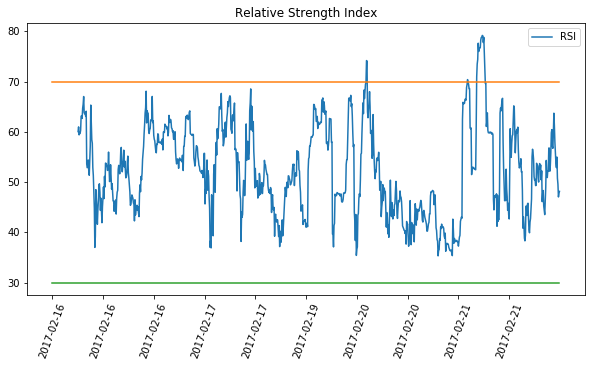

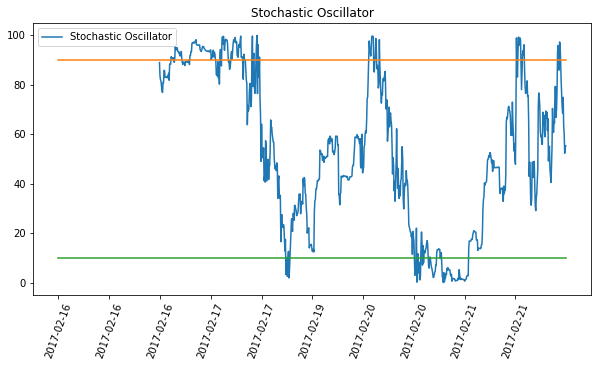

In [8]:
# -- Indicators Functions to Open and Close positions -- #
PIP_Conversion = 10000  # Relation between the currency with USD in pips
RSI_Param_UP = 70 
RSI_Param_DW = 30 
STO_Param_UP = 90 
STO_Param_DW = 10 
TP = 200/PIP_Conversion
SL = 100/PIP_Conversion
Units = 1000  # Each operation unit

# -- Axes Legend -- #
n_tick = 10
list_a_ = [(np.floor(len(df1_Prices)/n_tick)), (np.floor(len(df1_Prices)/n_tick))]
list_b_ = [np.arange(n_tick)]
c = [a*b for a, b in zip(list_a_, list_b_)]
d = tuple([(str(df1_Prices['TimeStamp'][i])[0:10]) for i in c[0]])
# -- Bollinger Bands Graph -- #
plt.figure(1, figsize=(10, 5))
plt.title('Close Price and Bollinger Bands')
plt.plot(df1_Prices['Close'], label='Close')
plt.plot(df1_Prices['BBH_Close'], label='BBH')
plt.plot(df1_Prices['BBL_Close'], label='BBL')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- RSI Graph -- #
plt.figure(2, figsize=(10, 5))
plt.title('Relative Strength Index')
plt.plot(df1_Prices['RSI_Close'], label='RSI')
plt.plot(np.ones(len(df1_Prices))*RSI_Param_UP)
plt.plot(np.ones(len(df1_Prices))*RSI_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- Stochastic Oscilator Graph -- #
plt.figure(3, figsize=(10, 5))
plt.title('Stochastic Oscillator')
plt.plot(df1_Prices['STO_Close'], label='Stochastic Oscillator')
plt.plot(np.ones(len(df1_Prices))*STO_Param_UP)
plt.plot(np.ones(len(df1_Prices))*STO_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()


This part of the code manage the opening and closing of positions thought out the period of time of the historical data with the parameters mentioned above. The expected result is a DataFrame with all the transactions made, including the closed and open positions, and another DataFrame with the account balance through time. 

In [9]:
RSI_Param_UP_ = [68, 69, 70, 71, 72]
RSI_Param_DW_ = [32, 31, 30, 29, 28]
STO_Param_UP_ = [87, 88, 89, 90, 91, 92, 93]
STO_Param_DW_ = [13, 12, 11, 10, 9, 8, 7]
Rend_Df = pd.DataFrame()
name = list()
for k in range(len(RSI_Param_DW_)):
    for m in range(len(STO_Param_DW_)):        
        RSI_Param_UP = RSI_Param_UP_[k]
        RSI_Param_DW = RSI_Param_DW_[k]
        STO_Param_UP = STO_Param_UP_[m]
        STO_Param_DW = STO_Param_DW_[m]
        Cap_In = 100000    
        
        df2_Ops = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Op_Type', 'Comment',
                                        'Units', 'Spot', 'TP', 'SL', 'Close_P', 'Close_Reason', 
                                        'Status', 'Margin'])
        # -- Op Open and Close Algorithm -- #
        for n_ in range(len(df1_Prices)):
            # -- Add Operation -- #
            if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1   
            elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1  
            elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                   df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1     
            elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
                df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                                   Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                   df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
                df2_Ops.index = df2_Ops.index + 1
            else:
                pass
            # -- Check and Close Op -- #
            df_Temp = df2_Ops[df2_Ops['Status'] == 'Open']
            for n_2 in df_Temp.index:
                if df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'TP'
                elif df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'SL'
                elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'TP'
                elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
                    df2_Ops['Status'][n_2] = 'Closed'
                    df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
                    df2_Ops['Margin'][n_2] = df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_]
                    df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
                    df2_Ops['Close_Reason'][n_2] = 'SL'
                else:
                    pass
        name.append(str(k) + '_' + str(k) + '_' + str(m) + '_' + str(m))
        df2_Ops = df2_Ops[df2_Ops['Status'] == 'Closed']
        Rends = df2_Ops['Margin']*df2_Ops['Units']
        Rends_Acu = Rends.cumsum() * Cap_In/100
        Rend_Df = Rend_Df.append(Rends_Acu, 1)
Rend_Df = Rend_Df.T
Rend_Df.columns = name  # The name of each column represents the index of the parameters
max_row = list(Rend_Df.iloc[0, :])
max_id = max_row.index(max(max_row))
max_name = Rend_Df.columns[max_id]
max_split = max_name.split('_')  # ['3', '3', '6', '6']
print('The best parameters are:')
print('RSI_Param_UP: ' + str(RSI_Param_UP_[int(max_split[0])]))
print('RSI_Param_DW: ' + str(RSI_Param_DW_[int(max_split[1])]))
print('STO_Param_UP: ' + str(STO_Param_UP_[int(max_split[2])]))
print('STO_Param_DW: ' + str(STO_Param_DW_[int(max_split[3])]))


The best parameters are:
RSI_Param_UP: 71
RSI_Param_DW: 29
STO_Param_UP: 93
STO_Param_DW: 7


With the best parameters for the technical analysis indicators, the same code will simulate transactions and balance for all data. Results wll be shown below. A initial capital of 100,000.00 is setup.

In [9]:
# -- Parameters -- #
RSI_Param_UP = RSI_Param_UP_[int(max_split[0])]  # 3
RSI_Param_DW = RSI_Param_DW_[int(max_split[1])]  # 3
STO_Param_UP = STO_Param_UP_[int(max_split[2])]  # 6
STO_Param_DW = STO_Param_DW_[int(max_split[3])]  # 6
df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # all data with size (151536, 6)
# df1_Prices = df1_Prices.iloc[:350, :]  # For sampling Data from the Data Set
Cap_In = 100000  
# -- Technical Analysis Indicators Calculations -- #
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], 
                                            df1_Prices['Close'], 200, False)
# -- Operations and Balance -- #
df2_Ops = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Op_Type', 'Comment',
                                'Units', 'Spot', 'TP', 'SL', 'Close_P', 'Close_Reason', 
                                'Status', 'Margin'])
df3_Acc = pd.DataFrame(columns=['Date', 'Cash', 'Float', 'Balance', 'Yield_Balance_Acu %',
                                'Comment', 'Earn/Loss'])
df3_Acc.loc[-1] = [str(df1_Prices['TimeStamp'][0])[0:16], Cap_In, 0, Cap_In + 0,
                   (((Cap_In + 0)/Cap_In)-1)*100, '-', (Cap_In + 0)-Cap_In]
# -- Op Open and Close Algorithm -- #
for n_ in range(len(df1_Prices)):
    # -- Add Operation -- #
    if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1   
    elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1  
    elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                           df1_Prices['Close'][n_] - SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1     
    elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
        df2_Ops.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                           Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                           df1_Prices['Close'][n_] + SL, '-', '-', 'Open', '-']
        df2_Ops.index = df2_Ops.index + 1
    else:
        pass
    # -- Check and Close Op -- #
    df_Temp = df2_Ops[df2_Ops['Status'] == 'Open']
    for n_2 in df_Temp.index:
        if df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'TP'
        elif df_Temp['Op_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df1_Prices['Close'][n_] - df2_Ops['Spot'][n_2])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'SL'
        elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'TP'
        elif df_Temp['Op_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
            df2_Ops['Status'][n_2] = 'Closed'
            df2_Ops['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Ops['Margin'][n_2] = float(df2_Ops['Spot'][n_2] - df1_Prices['Close'][n_])
            df2_Ops['Close_P'][n_2] = df1_Prices['Close'][n_]
            df2_Ops['Close_Reason'][n_2] = 'SL'
        else:
            pass
    float_M = -sum(df2_Ops[df2_Ops['Status'] == 'Open']['Units'])*df1_Prices['Close'][n_]
    cash_M = (sum(df2_Ops[df2_Ops['Status'] == 'Closed']['Margin'])*Units) + Cap_In - float_M
    Balance = cash_M + float_M
    Yield = (Balance - Cap_In)/Cap_In
    if Yield >= 0:
        Com_ = 'Earn'
    else:
        Com_ = 'Loss'
    E_L = Balance - Cap_In
    df3_Acc.loc[-1] = [str(df1_Prices['TimeStamp'][n_])[0:16], cash_M, float_M, 
                       Balance, Yield, 'Closed operations with ' + Com_ + 'of:', E_L]
    df3_Acc.index = df3_Acc.index + 1
# df3_Acc.to_csv('Acc.csv')
# df2_Ops.to_csv('Ops.csv')
# df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # all data with size (151536, 6)
# df2_Ops = pd.read_csv('Ops.csv')
# df3_Acc = pd.read_csv('Acc.csv')


In [10]:
print('Closed Operations')
df2_Ops[df2_Ops['Status'] == 'Closed']


Closed Operations


,Unnamed: 0,Folio,Ini_Date,End_Date,Op_Type,Comment,Units,Spot,TP,SL,Close_P,Close_Reason,Status,Margin
0,36962,Folio,2017-02-16 20:15,2017-02-16 20:25:00+00:00,Sell,BBH,1000,20.37046,20.35046,20.38046,20.39426,SL,Closed,-0.023799999999997823
1,36961,Folio,2017-02-16 20:20,2017-02-16 20:25:00+00:00,Sell,BBH,1000,20.37594,20.35594,20.38594,20.39426,SL,Closed,-0.018319999999999226
2,36960,Folio,2017-02-16 20:25,2017-02-16 20:55:00+00:00,Sell,BBH,1000,20.39426,20.37426,20.40426,20.37401,TP,Closed,0.020250000000000767
3,36959,Folio,2017-02-16 20:30,2017-02-16 20:35:00+00:00,Sell,BBH,1000,20.37495,20.35495,20.38495,20.38854,SL,Closed,-0.013590000000000657
4,36958,Folio,2017-02-16 20:35,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38854,20.36854,20.39854,20.41094,SL,Closed,-0.022400000000001086
5,36957,Folio,2017-02-16 20:40,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38708,20.36708,20.39708,20.41094,SL,Closed,-0.023859999999999104
6,36956,Folio,2017-02-16 20:45,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38690,20.36690,20.39690,20.41094,SL,Closed,-0.024039999999999395
7,36955,Folio,2017-02-16 21:10,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38682,20.36682,20.39682,20.41094,SL,Closed,-0.02411999999999992
8,36954,Folio,2017-02-16 21:15,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38642,20.36642,20.39642,20.41094,SL,Closed,-0.024519999999998987
9,36953,Folio,2017-02-16 21:20,2017-02-16 21:25:00+00:00,Sell,BBH,1000,20.38782,20.36782,20.39782,20.41094,SL,Closed,-0.023119999999998697


In [11]:
print('Open Operations')
df2_Ops[df2_Ops['Status'] == 'Open']


Open Operations


,Unnamed: 0,Folio,Ini_Date,End_Date,Op_Type,Comment,Units,Spot,TP,SL,Close_P,Close_Reason,Status,Margin
36958,4,Folio,2019-03-05 04:00,-,Sell,RSI,1000,19.31760,19.29760,19.32760,-,-,Open,-
36959,3,Folio,2019-03-05 04:05,-,Sell,RSI,1000,19.32095,19.30095,19.33095,-,-,Open,-
36960,2,Folio,2019-03-05 04:10,-,Sell,RSI,1000,19.32260,19.30260,19.33260,-,-,Open,-
36961,1,Folio,2019-03-05 04:15,-,Sell,RSI,1000,19.32241,19.30241,19.33241,-,-,Open,-
36962,0,Folio,2019-03-05 04:20,-,Sell,RSI,1000,19.32192,19.30192,19.33192,-,-,Open,-


The account balance through time is calculated in the next DataFrame:

In [12]:
# df3_Acc = df3_Acc.reset_index()
print(df3_Acc.shape)
df3_Acc.tail()


(151536, 10)


,Unnamed: 0,level_0,index,Date,Cash,Float,Balance,Yield_Balance_Acu %,Comment,Earn/Loss
151531,151531,151531,4,2019-03-05 04:30,267285.77,-96585.60,170700.17,0.707002,Closed operations with Earnof:,70700.17
151532,151532,151532,3,2019-03-05 04:35,267285.17,-96585.00,170700.17,0.707002,Closed operations with Earnof:,70700.17
151533,151533,151533,2,2019-03-05 04:40,267284.52,-96584.35,170700.17,0.707002,Closed operations with Earnof:,70700.17
151534,151534,151534,1,2019-03-05 04:45,267285.02,-96584.85,170700.17,0.707002,Closed operations with Earnof:,70700.17
151535,151535,151535,0,2019-03-05 04:50,267286.02,-96585.85,170700.17,0.707002,Closed operations with Earnof:,70700.17


The developement of the portfolio is shown in the next graph.

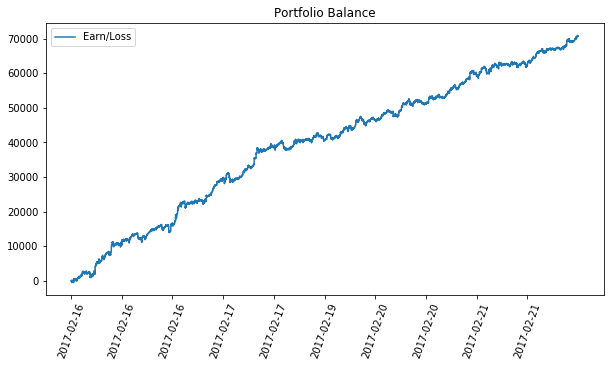

In [13]:
# -- Stochastic Oscilator Graph -- #
plt.figure(4, figsize=(10, 5))
plt.title('Portfolio Balance')
plt.plot(df3_Acc['Earn/Loss'], label='Earn/Loss')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()


In [15]:
Cap_In = 100000 
print('The final percentage of yield is:')
yield_ = df2_Ops[df2_Ops['Status'] == 'Closed']['Margin']
yield_ = sum(pd.to_numeric(yield_))
print(str(yield_*Units/Cap_In*100) + '%')


The final percentage of yield is:
70.70016999999886%


## Conclusion: /
The technical analysis had a 70.7% yield over 2 years. It is much more than any guburnamental of free risk rate available in the market. Of course there are no transaction fees in this model. For this badge, in the period of 16/02/2017-05/03/2019 the model prensented with the technical analysis indicators and parameters worked well. Technical Analysis i s a great tool to make investments with trading algorithms as well as manual trading. 


## Indicators Functions from Technical Analysis Library(ta) -- #
/
# These functions will add a column to the Historical DataFrame with the value of the indicator.
# T.A. library "ta" has implemented 32 indicators:
* Volume
  * Accumulation/Distribution Index (ADI)
  * On-Balance Volume (OBV)
  * On-Balance Volume mean (OBV mean)
  * Chaikin Money Flow (CMF)
  * Force Index (FI)
  * Ease of Movement (EoM, EMV)
  * Volume-price Trend (VPT)
  * Negative Volume Index (NVI)
* Volatility
  * Average True Range (ATR)
  * Bollinger Bands (BB)
  * Keltner Channel (KC)
  * Donchian Channel (DC)
* Trend
  * Moving Average Convergence Divergence (MACD)
  * Average Directional Movement Index (ADX)
  * Vortex Indicator (VI)
  * Trix (TRIX)
  * Mass Index (MI)
  * Commodity Channel Index (CCI)
  * Detrended Price Oscillator (DPO)
  * KST Oscillator (KST)
  * Ichimoku Kinkō Hyō (Ichimoku)
* Momentum
  * Money Flow Index (MFI)
  * Relative Strength Index (RSI)
  * True strength index (TSI)
  * Ultimate Oscillator (UO)
  * Stochastic Oscillator (SR)
  * Williams %R (WR)
  * Awesome Oscillator (AO)
* Others
  * Daily Return (DR)
  * Daily Log Return (DLR)
  * Cumulative Return (CR)
    

## Notas
* Paso 1: Data Frame (df1_precios) descargando todos los precios, segun fechas y granularidad, Fecha, Apertura, Maximo, Minimo, Cierre.

* Paso 2: Data Frame (df2_operaciones)
  * Fecha, Folio (1 a n), Operacion (1 = compra, -1 = venta), Unidades (0 a n),
  * Margen (0 a n), Comentario ("razon con base al indicador")
  * Precio_apertura, Precio_cierre

* Paso 3: Data Frame Cuenta (df3_cuenta)
  * Fecha, Capital (Efectivo $), Flotante ($),
  * Balance (Capital+Flotante), Rend_Balance_acm, Comentario ("Se abrio operacion: compra/venta", "Se cerro operacion: Con perdia de: / Con ganancia de: ", 

* Paso 4: Generar un vector de fechas, de F1 hasta F2
  * par0_cap = 100000   # Capital a utilizar $100,000 Usd
  * par1_mar = 1000000  # Unidades por operacion maximo 1'000,000

* Criterios para trading:
  * Para cerrar una operacion: 1) TP o SL, 2) Regla con indicador
  * indice = [1, 2, 3, 4, 5]
  * columnas = ['A','B', 'C', 'D']
  * df = pd.DataFrame(index=indice, columns=columnas)
  * df = df.fillna(0) # -- llenar todas las celdas con 0s